# 5 Training ML models with Serotiny
**Estimated time to run through notebook is 20 minutes** 

This notebook shows how to
-  [Load libraries, predefine some functions, and load the manifest ](#preprocessing) 
-  [5.1 Parametrize a ML task using serotiny's yamls](#param)
-  [5.2 Train a classification model based on 2D images](#train)
-  [5.3 Load and apply a trained model](#apply)
-  [5.4 Train a classification model based on 3D images](#train3D)
-  [Conclusion](#end)

#### Resources 
- Serotiny code: https://github.com/AllenCell/serotiny
- Serotiny documentation: https://allencell.github.io/serotiny
- Hydra for configurability https://hydra.cc/
- MLFlow for experiment tracking https://mlflow.org/
- Pytorch Lightning for DL training/testing/predictions https://pytorchlightning.ai/

## <a id='preprocessing'></a>Load libraries, predefine some functions, and load the manifest 


### Load libraries and predefined functions

In [1]:
from upath import UPath as Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nbvv

from serotiny.io.image import image_loader
from cytodata_aics.io_utils import rescale_image

11-Oct-22 20:54:33 - bfio.backends - WARNING  - Java backend is not available. This could be due to a missing dependency (jpype).


### Load the manifest and explore dimensions

In [2]:
#on-prem
#df = pd.read_parquet("s3://variancedataset/processed/hackathon_manifest_09292022.parquet")
#in-cloud
df = pd.read_parquet("s3://allencell-cytodata-variance-data/processed/hackathon_manifest_092022.parquet")
print(f'Number of cells: {len(df)}')
print(f'Number of columns: {len(df.columns)}')

Number of cells: 214037
Number of columns: 78


## <a id='param'></a>5.1 Parametrize a ML task using serotiny's yamls

`serotiny` is a Python package and framework to help you create configurable and reproducible DL projects. It uses [hydra](https://hydra.cc/) for configurability, [MLFlow](https://mlflow.org/) for experiment tracking,
and [Pytorch Lightning](https://pytorchlightning.ai/) for DL model training/testing/predictions.

### Project structure
With `serotiny` a DL project has a predefined structure (which this repo already complies with). To start a new project with the appropriate structure, you can use the [serotiny-project cookiecutter](https://github.com/allencellmodeling/serotiny-project-cookiecutter)

A serotiny project contains a Python package, and a config folder. This config folder is composed of 5 config groups:

<img src="resources/serotiny.png" width="700"/>


### `serotiny` commands
Aside from the predefined structure and config folder, `serotiny` has set of commands which know how to read a project's configuration (and override it)
and execute DL tasks.

For example, we could train a model using the a model config called `my_classifier` (which would live in `config/model/my_classifier.yaml`), and a data config
called `my_train_data` (which would live in `config/data/my_train_data.yaml`) and overriding some of the `mlflow` config parameters.
<br><small>Note: Because we didn't specify a top-level `mlflow` config, i.e. we didn't do `mlflow=...`, `serotiny` will use the default config, which lives in `config/mlflow/default.yaml`</small>

```
$ serotiny train model=my_classifier data=my_train_data mlflow.experiment_name=some_experiment mlflow.run_name=1st_run
```

Once the model finishes training, we could use it to make predictions on a different dataset, configured in `my_predict_data`

```
$ serotiny predict model=my_classifier data=my_predict_data mlflow.experiment_name=some_experiment mlflow.run_name=1st_run
```


## <a id='train'></a>5.2 Train a classification model based on 2D images


### Make a simple dataset of edge vs. non-edge cells

In [3]:
from serotiny.transforms.dataframe.transforms import split_dataframe

Path("/home/aicsuser/serotiny_data/").mkdir(parents=True, exist_ok=True)

n = 1000 # number of cells per class
cells_edgeVSnoedge = df.groupby("edge_flag").sample(n)

# Add the train, test and validate split
cells_edgeVSnoedge = split_dataframe(dataframe=cells_edgeVSnoedge, train_frac=0.7, val_frac=0.2, return_splits=False)

cells_edgeVSnoedge.to_csv("/home/aicsuser/serotiny_data/cells_edgeVSnoedge.csv") 
print(f"Number of cells: {len(cells_edgeVSnoedge)}")
print(f"Number of columns: {len(cells_edgeVSnoedge.columns)}")

Number of cells: 2000
Number of columns: 79


### Parametrize the data and model configurations

#### `data` config

```yaml
_target_: serotiny.datamodules.ManifestDatamodule

path: /home/aicsuser/serotiny_data/cells_edgeVSnoedge.csv

batch_size: 64
num_workers: 1
loaders:
  id:
    _target_: serotiny.io.dataframe.loaders.LoadColumn
    column: CellId
    dtype: int
  class:
    _target_: serotiny.io.dataframe.loaders.LoadColumn
    column: edge_flag
    dtype: float32
  image:
    _target_: serotiny.io.dataframe.loaders.LoadImage
    column: max_projection_z
    select_channels: ['membrane']  
    
split_column: "split"
```

#### `model` config

```yaml
_target_: serotiny.models.BasicModel
x_label: image
y_label: class
network:
  _target_: torch.nn.Sequential
  _args_:
    # conv block 1
    - _target_: torch.nn.LazyConv2d
      out_channels: 4
      kernel_size: 3
      stride: 1
    - _target_: torch.nn.LeakyReLU
    - _target_: torch.nn.LazyBatchNorm2d

    # conv block 2
    - _target_: torch.nn.LazyConv2d
      out_channels: 4
      kernel_size: 3
      stride: 1
    - _target_: torch.nn.LeakyReLU
    - _target_: torch.nn.LazyBatchNorm2d
    
    # conv block 3
    - _target_: torch.nn.LazyConv2d
      out_channels: 4
      kernel_size: 3
      stride: 1
    - _target_: torch.nn.LeakyReLU
    - _target_: torch.nn.LazyBatchNorm2d

    # flatten and feed through linear layer
    - _target_: serotiny.networks.layers.Flatten
    - _target_: torch.nn.LazyLinear
      out_features: 1
    - _target_: torch.nn.Sigmoid
    
loss:
  _target_: torch.nn.BCELoss
  
# a function used by `serotiny predict` to store the results of feeding data through the model
save_predictions:
  _target_: cytodata_aics.model_utils.save_predictions_classifier
  _partial_: true

# fields to include in the output for each batch
fields_to_log:
  - id
 
```

#### `trainer`, `trainer/callbacks` and `mlflow`

We provided sensible defaults to these config sections, but invite and recommend you to take a look at them and change them as you see fit
(in `/home/aicsuser/cytodata-hackathon-base/cytodata_aics/config/...`)

#### Changing the working directory

In [4]:
# we need the commands we type to be ran from the serotiny project root
# (because that's what `serotiny` expects) so we change directories here,
# so we can run commands within the notebook
import os
os.chdir("/home/aicsuser/cytodata-hackathon-base")

#### Creating a run name based on the current date and time

In [5]:
from datetime import datetime

# util to avoid referring to the same run unintentionally
now_str = lambda : datetime.now().strftime("%Y%m%d_%H%M%S")

#### Starting a training. Track the training at https://mlflow.a100.int.allencell.org/ (on-prem) OR http://mlflow.cytodata.allencell.org/ (in cloud)

In [ ]:
run_name = f"memdna_yproj_{now_str()}"
print(run_name)

!serotiny train \
    model=example_classifier_2d \
    data=example_dataloader_2d \
    mlflow.experiment_name=cytodata_chapter5 \
    mlflow.run_name={run_name} \
    trainer.gpus=[0] \
    trainer.max_epochs=10

memdna_yproj_20221011_215214
[2022-10-11 21:52:19,328][torch.distributed.nn.jit.instantiator][INFO] - Created a temporary directory at /tmp/tmpmvp5xu8m
[2022-10-11 21:52:19,329][torch.distributed.nn.jit.instantiator][INFO] - Writing /tmp/tmpmvp5xu8m/_remote_module_non_scriptable.py
[2022-10-11 21:52:19,639][pytorch_lightning.utilities.seed][INFO] - Global seed set to 42
[2022-10-11 21:52:19,640][serotiny.ml_ops.ml_ops][INFO] - Instantiating datamodule
[2022-10-11 21:52:23,195][serotiny.ml_ops.ml_ops][INFO] - Instantiating trainer
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
[2022-10-11 21:52:23,388][pytorch_lightning.utilities.rank_zero][INFO] - GPU available: True (cuda), used: True
[2022-10-11 21:52:23,388][pytorch_lightning.utilit

## <a id='apply'></a>5.3 Load and apply a trained model

### Make predictions based on the model we just trained

In [12]:
!serotiny predict \
    model=example_classifier_2d \
    data=example_dataloader_2d \
    mlflow.experiment_name=cytodata_chapter5 \
    mlflow.run_name={run_name} \
    trainer.gpus=[0]

[2022-10-11 21:42:57,576][torch.distributed.nn.jit.instantiator][INFO] - Created a temporary directory at /tmp/tmp76ouymbl
[2022-10-11 21:42:57,577][torch.distributed.nn.jit.instantiator][INFO] - Writing /tmp/tmp76ouymbl/_remote_module_non_scriptable.py
[2022-10-11 21:42:57,778][pytorch_lightning.utilities.seed][INFO] - Global seed set to 42
[2022-10-11 21:42:57,779][serotiny.ml_ops.ml_ops][INFO] - Instantiating datamodule
[2022-10-11 21:43:00,228][serotiny.ml_ops.ml_ops][INFO] - Instantiating trainer
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
[2022-10-11 21:43:00,485][pytorch_lightning.utilities.rank_zero][INFO] - GPU available: True (cuda), used: True
[2022-10-11 21:43:00,485][pytorch_lightning.utilities.rank_zero][INFO] - TPU av

### Retrieving predictions from MLFlow

In [13]:
import mlflow
from serotiny.ml_ops.mlflow_utils import download_artifact

In [14]:
# on-prem
# mlflow.set_tracking_uri("https://mlflow.a100.int.allencell.org")
#in-cloud
mlflow.set_tracking_uri("http://mlflow.cytodata.allencell.org")

with download_artifact("predictions/model_predictions.csv", experiment_name="cytodata_chapter5", run_name=run_name) as path:
    predictions_2d_df = pd.read_csv(path)
    

In [15]:
predictions_2d_df = predictions_2d_df.merge(cells_edgeVSnoedge[['CellId','split']].rename(columns={'CellId':'id'}), on = 'id')
predictions_2d_df

,id,y,yhat,loss,split
0,263126,0.0,0.331562,0.335765,valid
1,970164,0.0,0.030949,0.335765,train
2,492616,0.0,0.188883,0.335765,train
3,371543,0.0,0.638756,0.335765,train
4,609537,0.0,0.288383,0.335765,train
...,...,...,...,...,...
1995,524225,1.0,0.915787,0.470224,train
1996,683188,1.0,0.840120,0.470224,train
1997,560333,1.0,0.799574,0.470224,train
1998,616853,1.0,0.319558,0.470224,train


### Distribution of the continuous class predictions

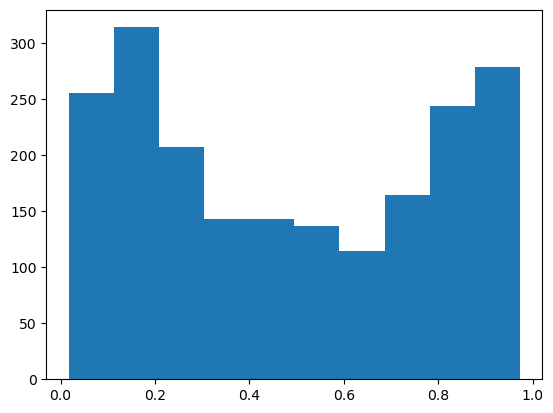

In [16]:
plt.hist(predictions_2d_df.yhat.to_numpy())
plt.show()

### Confusion matrices of train, valid and test splits 

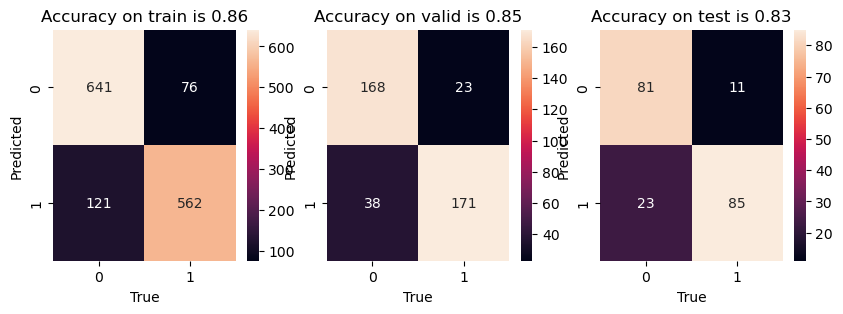

In [17]:
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report

# make confusion matrix for each split
splits = ['train','valid','test']
fig, axes = plt.subplots(nrows=1,ncols=len(splits),figsize=(10, 3), dpi=100)

for i,split in enumerate(splits):
    
    y_true = predictions_2d_df[predictions_2d_df['split']==split]['y'].to_numpy()
    y_pred = predictions_2d_df[predictions_2d_df['split']==split]['yhat'].to_numpy()
    y_pred = np.round(y_pred) #get to crisp binary class labels from posterior probability

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)    
    score = accuracy_score(y_true,y_pred) #compute accuracy score
    cm_df = pd.DataFrame(cm)
    sns.heatmap(cm_df, annot=True, fmt='d',ax = axes[i])
    axes[i].set_title(f'Accuracy on {split} is {score:.2f}')
    axes[i].set_xlabel('True')
    axes[i].set_ylabel('Predicted')

plt.show()



## <a id='train3D'></a> 5.4 Train a classification model based on 3D images

### Configure the 5 yamls and run the training

In [13]:
run_name = f"some_3d_run_{now_str()}"

!serotiny train \
    model=example_classifier_3d \
    data=example_dataloader_3d \
    mlflow.experiment_name=cytodata_chapter5 \
    mlflow.run_name={run_name} \
    ++data.loaders.image.unsqueeze_first_dim=True \
    ++data.loaders.image.ome_zarr_level=1 \
    trainer.gpus=[0] \
    trainer.max_epochs=1 

[2022-10-10 21:39:05,805][torch.distributed.nn.jit.instantiator][INFO] - Created a temporary directory at /tmp/tmpt4kyqsl6
[2022-10-10 21:39:05,806][torch.distributed.nn.jit.instantiator][INFO] - Writing /tmp/tmpt4kyqsl6/_remote_module_non_scriptable.py
[2022-10-10 21:39:06,005][pytorch_lightning.utilities.seed][INFO] - Global seed set to 42
[2022-10-10 21:39:06,006][serotiny.ml_ops.ml_ops][INFO] - Instantiating datamodule
[2022-10-10 21:39:08,479][serotiny.ml_ops.ml_ops][INFO] - Instantiating trainer
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
[2022-10-10 21:39:08,753][pytorch_lightning.utilities.rank_zero][INFO] - GPU available: True (cuda), used: True
[2022-10-10 21:39:08,753][pytorch_lightning.utilities.rank_zero][INFO] - TPU av

Note: The above task takes more the 16GB (it will not fit on the AWS computers) 45618MiB / 81920MiB

### Make predictions from the pretrained model

In [14]:
!serotiny predict \
    model=example_classifier_3d \
    data=example_dataloader_3d \
    mlflow.experiment_name=cytodata_chapter5 \
    mlflow.run_name={run_name} \
    trainer.gpus=[0]

[2022-10-10 21:39:19,248][torch.distributed.nn.jit.instantiator][INFO] - Created a temporary directory at /tmp/tmp9xlbx5hz
[2022-10-10 21:39:19,248][torch.distributed.nn.jit.instantiator][INFO] - Writing /tmp/tmp9xlbx5hz/_remote_module_non_scriptable.py
[2022-10-10 21:39:19,451][pytorch_lightning.utilities.seed][INFO] - Global seed set to 42
[2022-10-10 21:39:19,452][serotiny.ml_ops.ml_ops][INFO] - Instantiating datamodule
[2022-10-10 21:39:21,952][serotiny.ml_ops.ml_ops][INFO] - Instantiating trainer
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
[2022-10-10 21:39:22,217][pytorch_lightning.utilities.rank_zero][INFO] - GPU available: True (cuda), used: True
[2022-10-10 21:39:22,217][pytorch_lightning.utilities.rank_zero][INFO] - TPU av

### Retrieving predictions from MLFlow

In [15]:
mlflow.set_tracking_uri("https://mlflow.a100.int.allencell.org")

with download_artifact("predictions/model_predictions.csv", experiment_name="cytodata_chapter5", run_name=run_name) as path:
    predictions_3d_df = pd.read_csv(path)

/home/aicsuser/.local/lib/python3.10/site-packages/serotiny/ml_ops/mlflow_utils.py:144: FutureWarning: ``mlflow.tracking.fluent.list_experiments`` is deprecated. This method will be removed in a future release. Use ``search_experiments()`` instead.
  for _experiment in mlflow.list_experiments():
/opt/conda/lib/python3.10/site-packages/mlflow/tracking/fluent.py:1066: FutureWarning: ``mlflow.tracking.client.MlflowClient.list_experiments`` is deprecated. This method will be removed in a future release. Use ``search_experiments()`` instead.
  return MlflowClient().list_experiments(
10-Oct-22 21:40:24 - urllib3.connectionpool - WARNING  - Retrying (Retry(total=4, connect=4, read=5, redirect=5, status=5)) after connection broken by 'NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f7a5ca1a170>: Failed to establish a new connection: [Errno -2] Name or service not known')': /api/2.0/mlflow/experiments/list?view_type=ACTIVE_ONLY&max_results=1000
10-Oct-22 21:40:28 - urllib3.

MlflowException: API request to https://mlflow.a100.int.allencell.org/api/2.0/mlflow/experiments/list failed with exception HTTPSConnectionPool(host='mlflow.a100.int.allencell.org', port=443): Max retries exceeded with url: /api/2.0/mlflow/experiments/list?view_type=ACTIVE_ONLY&max_results=1000 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f7a5c69a110>: Failed to establish a new connection: [Errno -2] Name or service not known'))

In [ ]:
predictions_3d_df = predictions_3d_df.merge(cells_edgeVSnoedge[['CellId','split']].rename(columns={'CellId':'id'}), on = 'id')
predictions_3d_df
# print(len(predictions_3d_df))

In [ ]:
plt.hist(predictions_3d_df.yhat.to_numpy())
plt.show()

### Confusion matrices of train, valid and test splits 

In [ ]:
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report

# make confusion matrix for each split
splits = ['train','valid','test']
fig, axes = plt.subplots(nrows=1,ncols=len(splits),figsize=(10, 3), dpi=100)

for i,split in enumerate(splits):
    
    y_true = predictions_3d_df[predictions_3d_df['split']==split]['y'].to_numpy()
    y_pred = predictions_3d_df[predictions_3d_df['split']==split]['yhat'].to_numpy()
    y_pred = np.round(y_pred) #get to crisp binary class labels from posterior probability

    # Computer confusion matrix
    cm = confusion_matrix(y_true, y_pred)    
    score = accuracy_score(y_true,y_pred) #compute accuracy score
    cm_df = pd.DataFrame(cm)
    sns.heatmap(cm_df, annot=True, fmt='d',ax = axes[i])
    axes[i].set_title(f'Accuracy on {split} is {score:.2f}')
    axes[i].set_xlabel('True')
    axes[i].set_ylabel('Predicted')

plt.show()

# <a id='end'></a>Conclusion
In this chapter you learned how to parametrize ML models using serotiny. We trained 2D and 3D models to distinguish edge from non-edge cells. In the next chapter you will learn what the hackathon tasks are. The data and tools that you have explored in this and previous chapters will be the basis for understanding and solving the hackathon tasks.